
Using the MNIST dataset, we want to test the following hypothesis. Make a simple neural network(multilayered), and train it on part of the MNIST dataset. For each node in the layer, we want to count for which class labels it got activated.
Find the infomation gain for each node, and sort the nodes in descending order of information gain. Then drop the nodes below a certain information gain threshold, and check the performance of the dataset on the test datasets. With increasing threshold, check the performance of the dataset on the test dataset.

Then we also make use of co-activation scores, while dropping nodes. The idea is to not select nodes with large co-activation score with an exisiting neuron in the selected neurons list. 

This approach is better than simple removal of nodes ordered by entropy measures.

In [49]:
import numpy as np
import matplotlib.pyplot as plt 
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import mutual_info_score
import numpy as np


In [50]:

# Load MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)




# Define a simple multilayered neural network
class Net(nn.Module):
    def __init__(self, hidden_layer_size):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28*28, hidden_layer_size)
        self.fc2 = nn.Linear(hidden_layer_size, 10)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [51]:
def train_model(hidden_layer_size):

    # Initialize the network
    model = Net(hidden_layer_size)

    # Define loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the network
    for epoch in range(10):  # loop over the dataset multiple times
        correct = 0
        total = 0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    #print(f"Epoch {epoch+1}, Training Accuracy: {100 * correct / total}%")
        
    return model

In [52]:
class InputStorer:
    def __init__(self,hidden_layer_size):
        self.num_neurons = hidden_layer_size  # Assuming no. of  neurons in the second layer
        self.num_classes = 10  # Assuming 10 classes
        self.inputs = {label: torch.zeros(self.num_neurons) for label in range(self.num_classes)}  # Assuming 10 classes
        self.count = {label: 0 for label in range(self.num_classes)}
        self.labels = None
        self.activation_score = np.zeros((self.num_neurons,self.num_neurons))
        self.deactivation_score = np.zeros((self.num_neurons,self.num_neurons))

    def store_inputs(self, module, input, output):
        for i, inp in enumerate(input[0]):  # Only iterate up to the batch size
            try:
                label = self.labels[i].item()  # Get the label for the current image
                self.inputs[label]+=inp
                self.count[label]+=1
                # for i in range(self.num_neurons):
                #     for j in range(i+1,self.num_neurons):
                #         if inp[i]*inp[j] > 0:
                #             self.activation_score[i][j] += 1
                #             self.activation_score[j][i] += 1
                #         elif (inp[i] or inp[j]):
                #             self.deactivation_score[i][j] += 1
                #             self.deactivation_score[j][i] += 1
            except:
                continue
                print("Error")

In [53]:
def get_activations(model,hidden_layer_neurons,train_loader):
    input_storer = InputStorer(hidden_layer_neurons)

    # Register the hooks and store the handles
    handle= model.fc2.register_forward_hook(input_storer.store_inputs)

    # Forward pass
    for images, labels in train_loader:
        input_storer.labels = labels
        output = model(images)
        
    # Now you can remove the hooks using the handles
    handle.remove()
    
    avg_inputs = {label: inputs/input_storer.count[label] for label, inputs in input_storer.inputs.items()}
    
    class_neurons = np.zeros((hidden_layer_neurons,10))
    for i in range(hidden_layer_neurons):
        for j in range(10):
            class_neurons[i][j] += avg_inputs[j][i].item()
        
        class_neurons[i] = class_neurons[i]/np.sum(class_neurons[i])
        
    # Calculate co-activation and co-deactivation scores
    co_activation = np.zeros((hidden_layer_neurons,hidden_layer_neurons))
    co_deactivation = np.zeros((hidden_layer_neurons,hidden_layer_neurons))
    for i in range(hidden_layer_neurons):
        for j in range(i+1,hidden_layer_neurons):
            for k in range(10):
                co_activation[i][j] += avg_inputs[k][i].item()*avg_inputs[k][j].item()/10
                co_activation[j][i] = co_activation[i][j]
                
    return co_activation, co_deactivation, class_neurons

# Pruning a feed forward network

In [66]:
def select_neurons_least_entropy(class_neurons,k):
    
    hidden_layer_neurons = len(class_neurons)
    entropy = np.zeros(hidden_layer_neurons)
    for i in range(hidden_layer_neurons):
        entropy[i] = 0
        for j in range(10):
            if class_neurons[i][j] != 0:
                entropy[i] -= class_neurons[i][j] * np.log(class_neurons[i][j])
    
    return np.argsort(entropy)[:k]

In [67]:
def select_neurons_entropy_ordered_lowest_coactivation_scores(class_neurons, co_activation, threshold=0.01, k=50):
    # select top k neurons with smallest entropy, such that the co_activation is low with previosuly selected neurons 
    # calculate entropy of each neuron
    
    hidden_layer_neurons = len(class_neurons)

    entropy = np.zeros(hidden_layer_neurons)
    for i in range(hidden_layer_neurons):
        entropy[i] = 0
        for j in range(10):
            if class_neurons[i][j] != 0:
                entropy[i] -= class_neurons[i][j] * np.log(class_neurons[i][j])

    # Assuming `activations` is a 2D numpy array where each row corresponds to a neuron and each column corresponds to an input
    # And `co_activation_scores` is a 2D numpy array where each element [i][j] is the co-activation score between neuron i and neuron j

    # Sort the neurons based on their entropy in ascending order
    sorted_neurons = np.argsort(entropy)

    # Select the top k neurons with the smallest entropy and low co-activation with previously selected neurons
    selected_neurons = []
    for neuron in sorted_neurons:
        if len(selected_neurons) == 0:
            # Select the neuron with the smallest entropy
            selected_neurons.append(neuron)
        elif len(selected_neurons) < k:
            # Calculate the average co-activation with the already selected neurons
            avg_co_activation = np.mean([co_activation[neuron][selected] for selected in selected_neurons])
            
            # If the average co-activation is below a certain threshold, select the neuron
            # The threshold can be adjusted based on your specific requirements
            if avg_co_activation < threshold:
                selected_neurons.append(neuron)
        
        # Stop if we have selected k neurons
        if len(selected_neurons) == k:
            break
        
    return selected_neurons

In [68]:
def prune_neurons_least_entropy(class_neurons, model, test_loader,hidden_layer_neurons):
    node_lost = []
    accuracy = []

    
    for k in np.arange(1,hidden_layer_neurons,20):
        
        # Step0: Select neurons to prune
        selected_neurons = select_neurons_least_entropy(class_neurons,k)

        # Make a copy of the original model
        copied_model = Net(hidden_layer_neurons)
        copied_model.load_state_dict(model.state_dict())

        # Step 1: Filter neurons
        for name, param in copied_model.named_parameters():
            if name == 'fc2.weight':  # Assuming 'fc1' is the layer you want to modify
                for neuron_index in selected_neurons:
                    param.data[:,neuron_index] = 0  # Zero out the neuron
            if name == "fc1.weight":
                for neuron_index in selected_neurons:
                    param.data[neuron_index] = 0

        # Step 2: Evaluate model on test data
        correct = 0
        total = 0
        copied_model.eval()

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = copied_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        accuracy.append(100 * correct / total)
        node_lost.append(hidden_layer_neurons - len(selected_neurons))
                

        #print(f"Accuracy of the model on the test data: {100 * correct / total}%  with only {hidden_layer_neurons - len(selected_neurons)} neurons. ")
    return node_lost, accuracy

In [69]:
def prune_neurons_entropy_ordered_lowest_coactivation_scores(class_neurons, co_activation, model, test_loader,hidden_layer_neurons):

    node_lost = []
    accuracy = []
    

    for threshold in [0.001,0.01, 0.02, 0.03, 0.04, 0.05, 0.1,0.2, 0.5,1.0]:
        
        # Step0: Select neurons to prune
        selected_neurons = select_neurons_entropy_ordered_lowest_coactivation_scores(class_neurons, co_activation, threshold=threshold, k=hidden_layer_neurons)

        # Make a copy of the original model
        copied_model = Net(hidden_layer_neurons)
        copied_model.load_state_dict(model.state_dict())

        # Step 1: Filter neurons
        for name, param in copied_model.named_parameters():
            if name == 'fc2.weight':  # Assuming 'fc1' is the layer you want to modify
                for neuron_index in selected_neurons:
                    param.data[:,neuron_index] = 0  # Zero out the neuron
            if name == "fc1.weight":
                for neuron_index in selected_neurons:
                    param.data[neuron_index] = 0

        # Step 2: Evaluate model on test data
        correct = 0
        total = 0
        copied_model.eval()

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = copied_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        accuracy.append(100 * correct / total)
        node_lost.append(hidden_layer_neurons - len(selected_neurons))
                

        #print(f"Accuracy of the model on the test data: {100 * correct / total}% for threshold: {threshold} with only {hidden_layer_neurons - len(selected_neurons)} neurons. ")
    return node_lost, accuracy

In [70]:
def random_pruning( model, test_loader,hidden_layer_neurons):

    node_lost = []
    accuracy = []
    

    for neurons in np.arange(1,hidden_layer_neurons,10):
        
        # Step0: Select neurons to prune
        selected_neurons = np.random.choice(hidden_layer_neurons,neurons,replace=False)

        # Make a copy of the original model
        copied_model = Net(hidden_layer_neurons)
        copied_model.load_state_dict(model.state_dict())

        # Step 1: Filter neurons
        for name, param in copied_model.named_parameters():
            if name == 'fc2.weight':  # Assuming 'fc1' is the layer you want to modify
                for neuron_index in selected_neurons:
                    param.data[:,neuron_index] = 0  # Zero out the neuron
            if name == "fc1.weight":
                for neuron_index in selected_neurons:
                    param.data[neuron_index] = 0

        # Step 2: Evaluate model on test data
        correct = 0
        total = 0
        copied_model.eval()

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                outputs = copied_model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        accuracy.append(100 * correct / total)
        node_lost.append(hidden_layer_neurons - len(selected_neurons))
                

        #print(f"Accuracy of the model on the test data: {100 * correct / total}% with only  {hidden_layer_neurons - len(selected_neurons)} neurons. ")
    return node_lost, accuracy

In [71]:
def run_experiment(hidden_layer_size, train_loader,test_loader):
    model = train_model(hidden_layer_size)
    co_activation, co_deactivation, class_neurons = get_activations(model,hidden_layer_size,train_loader)
    node_lost_entropy, accuracy_entropy = prune_neurons_least_entropy(class_neurons, model, test_loader,hidden_layer_size)
    node_lost_coactivation, accuracy_coactivation = prune_neurons_entropy_ordered_lowest_coactivation_scores(class_neurons, co_activation, model, test_loader,hidden_layer_size)
    node_lost_random, accuracy_random = random_pruning(model, test_loader,hidden_layer_size)
    return node_lost_entropy, accuracy_entropy, node_lost_coactivation, accuracy_coactivation, node_lost_random, accuracy_random

In [72]:
def make_plot(node_lost_entropy, accuracy_entropy, node_lost_coactivation, accuracy_coactivation, node_lost_random, accuracy_random,hidden_layer_size):
    plt.plot(node_lost_coactivation, accuracy_coactivation, label="Least Entropy with co-activation score")
    plt.plot(node_lost_entropy, accuracy_entropy, label="Least Entropy")
    plt.plot(node_lost_random, accuracy_random, label="Random Pruning")
    plt.xlabel("Number of neurons left after pruning using training data")
    plt.ylabel("Accuracy on test data")
    plt.title("Neurons Pruning using different methods for hidden layer size:"+str(hidden_layer_size))
    plt.legend()
    plt.yticks(np.arange(0,hidden_layer_size,10))
    plt.xticks(np.arange(0,101,10))
    plt.savefig("hidden_layer_size_"+str(hidden_layer_size)+".png")
    plt.show()

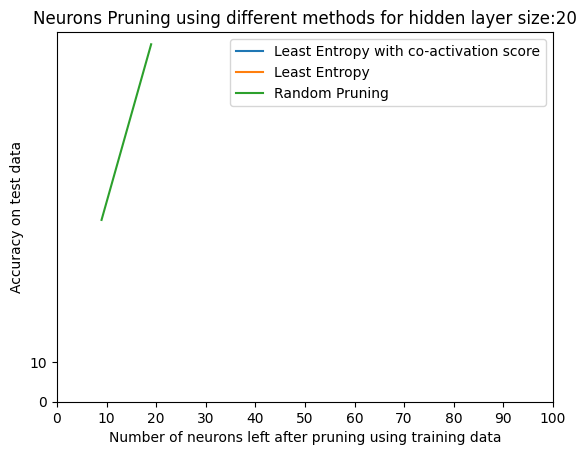

KeyboardInterrupt: 

In [73]:
# compare for different hidden layer sizes
for hidden_layer_size in [20,30,50,100,200,300,500,1000]:
    node_lost_entropy, accuracy_entropy, node_lost_coactivation, accuracy_coactivation, node_lost_random, accuracy_random = run_experiment(hidden_layer_size, train_loader,test_loader)
    make_plot(node_lost_entropy, accuracy_entropy, node_lost_coactivation, accuracy_coactivation, node_lost_random, accuracy_random,hidden_layer_size)

# Learning the input from model 

In [105]:
# Assume `model` is your model and `input` is your input tensor
# Assume `optimizer` is the optimizer for your model
# Assume `criterion` is the loss function for your model

# Number of epochs
epochs = 1000
inputs = torch.rand(100, 1, 28, 28, requires_grad=True)


# Include `inputs` in the parameters that the optimizer is tracking
optimizer = torch.optim.SGD([ {'params': inputs}], lr=1)

# Then, in your training loop:
for epoch in range(epochs):
    # Forward pass
    output = model(inputs)
    
    target = torch.tensor([3]*100,dtype=torch.long)

    # Calculate the loss
    loss = criterion(output, target)

    # Backpropagate the loss
    loss.backward()

    # Update the weights AND inputs
    optimizer.step()
    
    # Get the gradients of the inputs
    input_gradients = inputs.grad

    # Zero the gradient buffers
    optimizer.zero_grad()

    # Print loss for every epoch
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")
    #plt.imshow(inputs.detach().numpy().reshape(28,28),cmap='gray')
    #plt.show()
    
    

Epoch 1, Loss: 6.544097423553467
Epoch 2, Loss: 6.404799938201904
Epoch 3, Loss: 6.2662506103515625
Epoch 4, Loss: 6.128225326538086
Epoch 5, Loss: 5.99028205871582
Epoch 6, Loss: 5.8523030281066895
Epoch 7, Loss: 5.714568614959717
Epoch 8, Loss: 5.577173233032227
Epoch 9, Loss: 5.440344333648682
Epoch 10, Loss: 5.304072856903076
Epoch 11, Loss: 5.168038368225098
Epoch 12, Loss: 5.032655715942383
Epoch 13, Loss: 4.897667407989502
Epoch 14, Loss: 4.763254165649414
Epoch 15, Loss: 4.629744529724121
Epoch 16, Loss: 4.496885776519775
Epoch 17, Loss: 4.364274501800537
Epoch 18, Loss: 4.232733249664307
Epoch 19, Loss: 4.102503776550293
Epoch 20, Loss: 3.9737465381622314
Epoch 21, Loss: 3.8461825847625732
Epoch 22, Loss: 3.7198238372802734
Epoch 23, Loss: 3.594808578491211
Epoch 24, Loss: 3.4713099002838135
Epoch 25, Loss: 3.3495218753814697
Epoch 26, Loss: 3.2296764850616455
Epoch 27, Loss: 3.1116721630096436
Epoch 28, Loss: 2.995748281478882
Epoch 29, Loss: 2.882200002670288
Epoch 30, Loss:

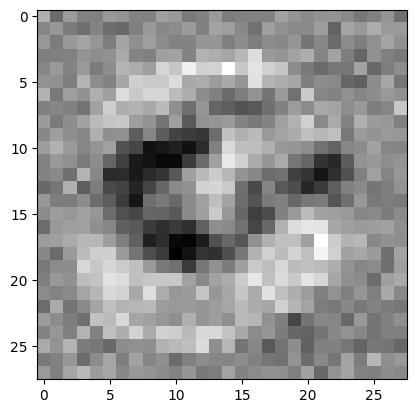

In [106]:
plt.imshow(inputs.mean(axis=0).detach().numpy().reshape(28,28),cmap='gray')
plt.show()

In [107]:
threshold = 0
activated_inputs = (input_gradients.mean(axis=0) > threshold).float()

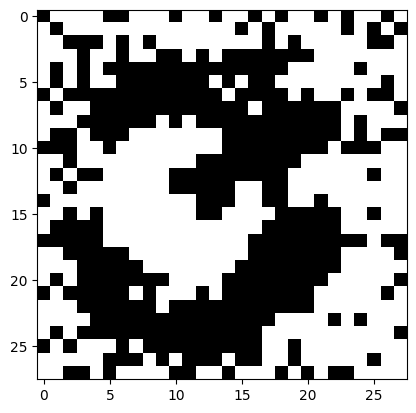

In [108]:
plt.imshow(activated_inputs[0],cmap='gray')